# Предсказания загруженности таксопарка по времени

Имеются исторические данные о заказах такси в аэропортах.
Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.
Необходимо построить оптимальную модель для такого предсказания.

## 1. Загрузка и анализ данных

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from statsmodels.tsa.seasonal import seasonal_decompose

#preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

# метрики

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import r2_score

In [2]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


В нашем распоряжении данные о кол-ве заказов с марта по август(включительно) 2018 года.
Временной интервал - 10 минут.

Сделаем ресемплирование данных за 1 час. В качестве агреггирующей функции для этого используем сумму.

In [4]:
data = data.resample('1H').sum()

## 2. Подготовка признаков

Подготовим новые признаки для обучения модели:
* Среднее кол-во заказов за последние 24 часа (roll_24_mean)
* Данные о кол-ве заказов за последние 6 часов (lag_*)
* Час (hour)
* День недели (weekday),
* Месяц (month)

In [5]:
# mean for last 24 hours
data['roll_24_mean'] = data['num_orders'].shift().rolling(24).mean()
data.head(25)

,num_orders,roll_24_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN
2018-03-01 05:00:00,6,NaN
2018-03-01 06:00:00,12,NaN
2018-03-01 07:00:00,15,NaN
2018-03-01 08:00:00,34,NaN


In [6]:
# values for last 6 hours
for i in range(1,7):
    data['lag_{}'.format(i)] = data['num_orders'].shift(i)
data.head()

,num_orders,roll_24_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,66.0,71.0,85.0,124.0,NaN,NaN


Т.к. данные только за полгода- мы не увидим годовой сезонности.
Добавим следующие признаки (категории):
* День недели (0-6)
* Час (0-23)
* Месяц

In [7]:
data['month'] = data.index.month
data['weekday'] = data.index.dayofweek
data['hour'] = data.index.hour
data.head()

,num_orders,roll_24_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,month,weekday,hour
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,0
2018-03-01 01:00:00,85,NaN,124.0,NaN,NaN,NaN,NaN,NaN,3,3,1
2018-03-01 02:00:00,71,NaN,85.0,124.0,NaN,NaN,NaN,NaN,3,3,2
2018-03-01 03:00:00,66,NaN,71.0,85.0,124.0,NaN,NaN,NaN,3,3,3
2018-03-01 04:00:00,43,NaN,66.0,71.0,85.0,124.0,NaN,NaN,3,3,4


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


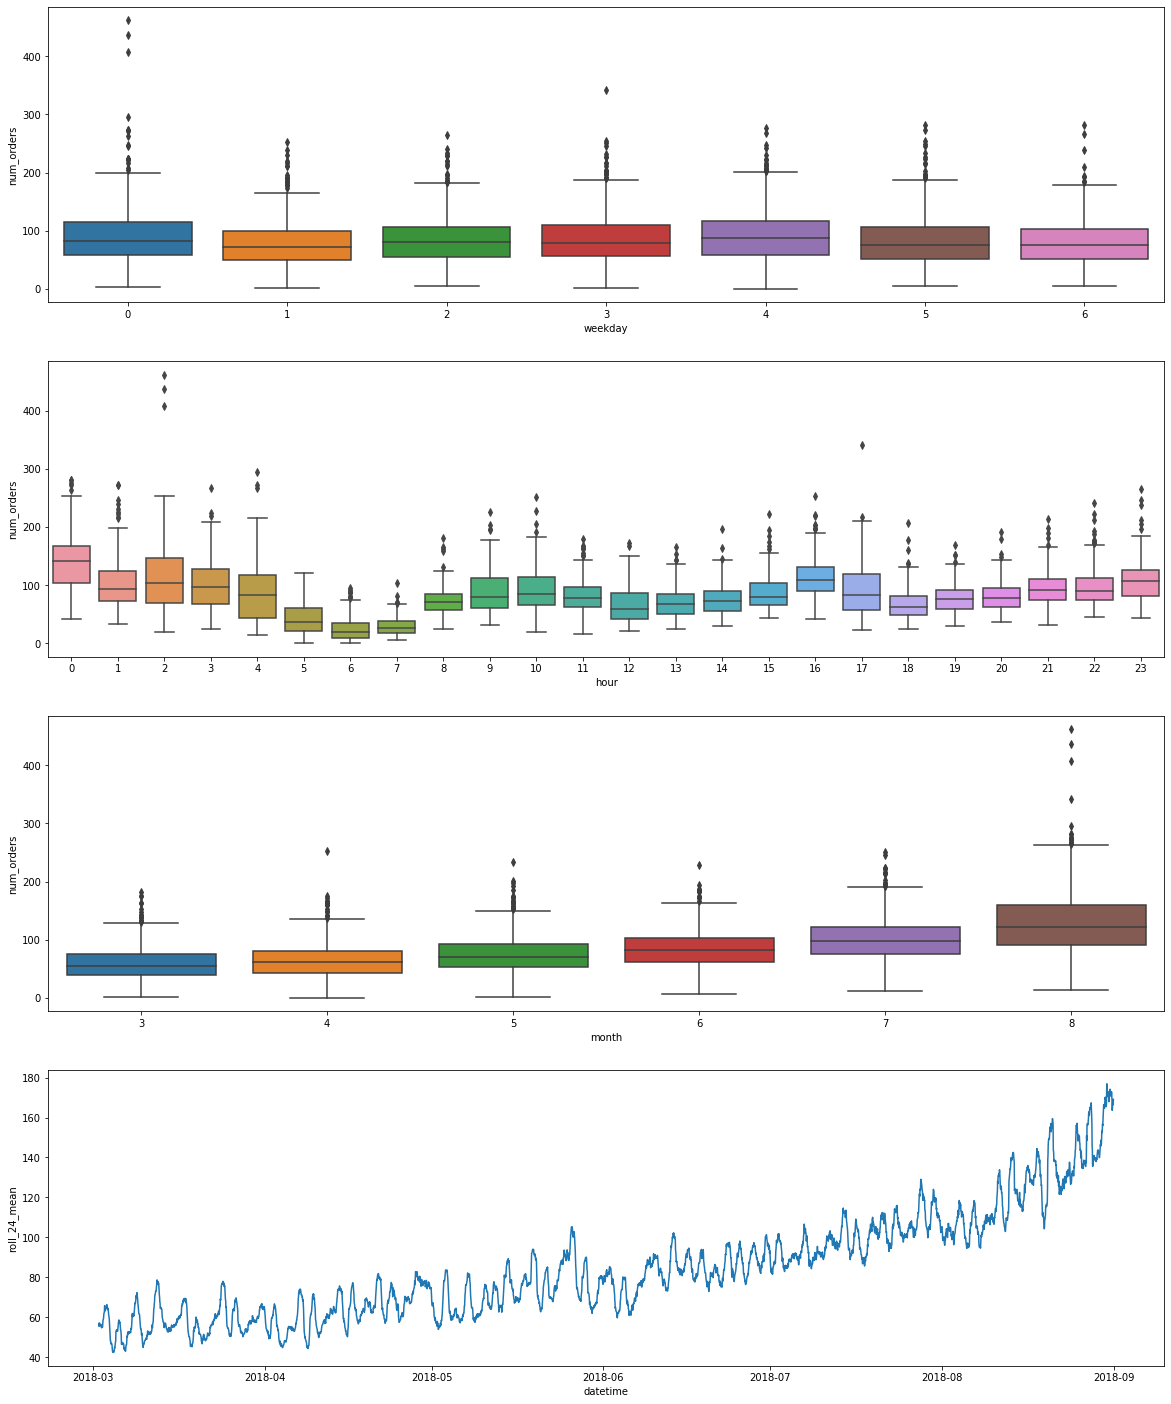

In [8]:
# посмотрим немного на графики
fig, ax = plt.subplots(4,1, figsize=(20,25))
sns.boxplot(ax=ax[0], data=data, x='weekday', y='num_orders')
sns.boxplot(ax=ax[1], data=data, x='hour', y='num_orders')
sns.boxplot(ax=ax[2], data=data, x='month', y='num_orders')
sns.lineplot(ax=ax[3], data=data, x=data.index, y='roll_24_mean')
plt.show()

Видно, как меняется кол-во заказов в течение суток. Также очевидна тенденция роста среднего кол-ва заказов от месяца к месяцу.

In [9]:
# удаляем получившиеся пропуски
data.dropna(inplace=True)

In [10]:
# разбиваем даные на выборки

target=data['num_orders']
features=data.drop('num_orders', axis=1)

# OHE
cat_features = ['weekday', 'hour', 'month']
features_ohe = pd.get_dummies(features, columns=cat_features)

f_train, f_test, t_train, t_test = train_test_split(features, target, shuffle=False, test_size=0.1)
f_train_ohe, f_test_ohe = train_test_split(features_ohe, shuffle=False, test_size=0.1)

print('Features train:', f_train.shape)
print('Target train:', t_train.shape)
print('---')
print('Features OHE train:', f_train_ohe.shape)
print('Features OHE test:', f_test_ohe.shape)
print('---')
print('Features test:', f_test.shape)
print('Target test:', t_test.shape)

Features train: (3952, 10)
Target train: (3952,)
---
Features OHE train: (3952, 44)
Features OHE test: (440, 44)
---
Features test: (440, 10)
Target test: (440,)


## 3. Обучение моделей

In [11]:
# функция для скорринга
def score_me(model, ohe=True):
    if ohe==True:
        train_pred = model.predict(f_train_ohe)
        pred = model.predict(f_test_ohe)
    else:
        train_pred = model.predict(f_train)
        pred = model.predict(f_test)

    mse_train = mean_squared_error(t_train, train_pred)
    mse = mean_squared_error(t_test, pred)

    print('RMSE on TRAIN:', mse_train**0.5)
    print('RMSE on TEST:', mse**0.5)
    
    plot_df = pd.DataFrame(t_test, index=t_test.index)
    plot_df['predict_orders'] = pred


    fig=plt.figure(figsize=(16,8))
    ax1=fig.add_subplot(2,1,1)
    plot_df['2018-8-18':'2018-8-20'].plot(ax=ax1,kind='line', marker='o', grid=True)
    plt.legend(plot_df.columns)
    ax1.set_title('True and predicted values for {}'.format(model.__class__.__name__))

    plot_df['dif'] = plot_df['num_orders'] - plot_df['predict_orders']
    plot_df['hour'] = plot_df.index.hour
    ax2=fig.add_subplot(2,1,2)

    plot_df['2018-8-18':'2018-8-20'].plot(x='hour', y='dif', kind='bar', ax=ax2, color='red')
    ax2.set_title('Error')
    plt.grid()
    plt.show()

    return mse**0.5

### 3.1 Median model

Смотрим константную модель. В данном случае медианную, для простоты.

In [12]:
median_train = t_train.median()
median_pred = np.full(t_test.shape, median_train)

# создадим табличку с результатами

result = pd.DataFrame(columns=['Model','RMSE'])
result=result.append({'Model':'median', 'RMSE': mean_squared_error(t_test, median_pred)**0.5}, ignore_index=True)
result

,Model,RMSE
0,median,87.210938


Посмотрим различные модели и соберём скоры.

### 3.2 RandomForest

In [13]:
# грид-серч для леса
def RFR_grid(feat, targ):
    estimator = RandomForestRegressor(random_state=112211)
    param_grid = {
            "n_estimators"      : [500,2000],
            "max_features"      : ["auto"],
            "max_depth" : [20],
            "min_samples_leaf" : [1],
            "min_samples_split" : [15],
            "bootstrap": [True]
    }

    rfr_grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error')
    rfr_grid.fit(feat, targ)

    print('...Search completed...')
    print('Best RMSE score', rfr_grid.best_score_)
    print('Best params:', rfr_grid.best_params_)

    return rfr_grid.best_params_

In [14]:
#RFR_params = RFR_grid(f_train_ohe, t_train)
RFR_params = {'bootstrap': True,
              'max_depth': 20,
              'max_features': 'auto',
              'min_samples_leaf': 1,
              'min_samples_split': 15,
              'n_estimators': 2000}

RMSE on TRAIN: 14.808081872960006
RMSE on TEST: 42.474017406857676


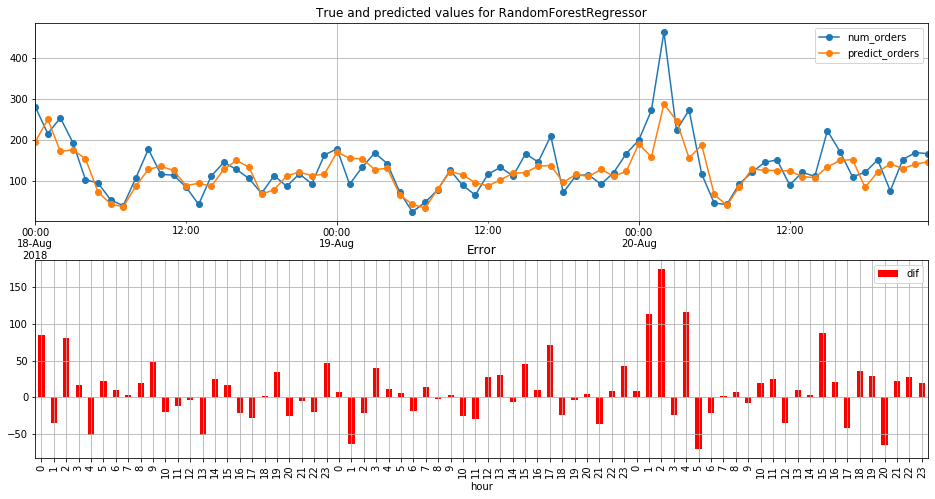

In [15]:
rfr_model = RandomForestRegressor(**RFR_params)
rfr_model.fit(f_train_ohe, t_train)

rfr_score = score_me(rfr_model)

In [16]:
result = result.append({'Model':'RandomForest', 'RMSE':rfr_score}, ignore_index=True)

### 3.3 LinearRegression

RMSE on TRAIN: 23.272825592237197
RMSE on TEST: 43.70153043993252


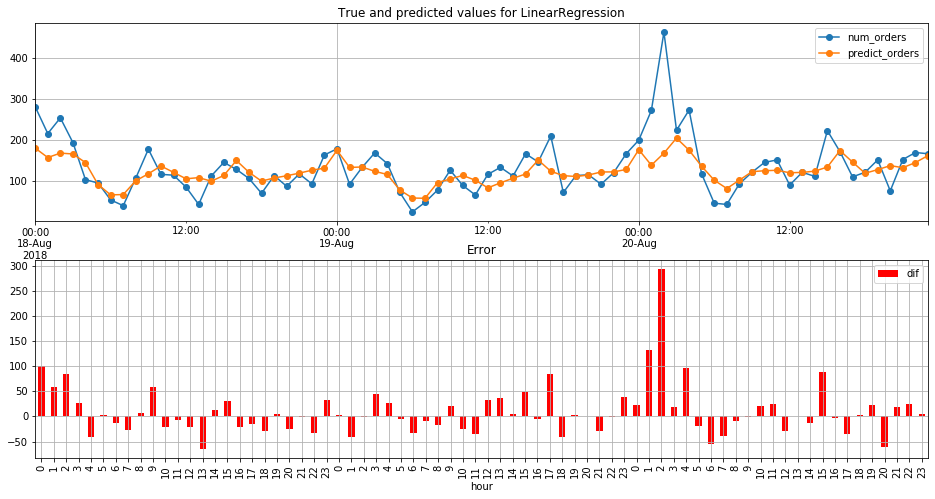

In [17]:
model_lr = LinearRegression()
model_lr.fit(f_train_ohe, t_train)

score_lr = score_me(model_lr)
result = result.append({'Model':'LinearReg', 'RMSE':score_lr}, ignore_index=True)

### 3.4 XGBoost

In [18]:
def XGB_cv_grid():
    xgb_m = xgb.XGBRegressor(random_state=112211)
    param_grid = {
            "n_estimators"      : [500, 1000, 2000],
            "learning_rate"     : [0.05, 0.01],
            "max_depth" : [5],
            "gamma" : [0.1, 0.5],
            "reg_lambda": [5,10],
            "min_child_weight" : [1]
            }

    xgb_grid = GridSearchCV(xgb_m, param_grid, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error')
    xgb_grid.fit(f_train_ohe, t_train)

    print('...Search completed...')
    print('Best RMSE score', xgb_grid.best_score_)
    print('Best params:', xgb_grid.best_params_)

    return xgb_grid.best_params_

In [19]:
#xgb_params = XGB_cv_grid()

xgb_params ={'gamma': 0.1,
             'learning_rate': 0.05,
             'max_depth': 5,
             'min_child_weight': 1,
             'n_estimators': 500,
             'reg_lambda': 10}
xgb_params

{'gamma': 0.1,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 500,
 'reg_lambda': 10}

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:52:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on TRAIN: 15.549821627431488
RMSE on TEST: 44.09083902537148


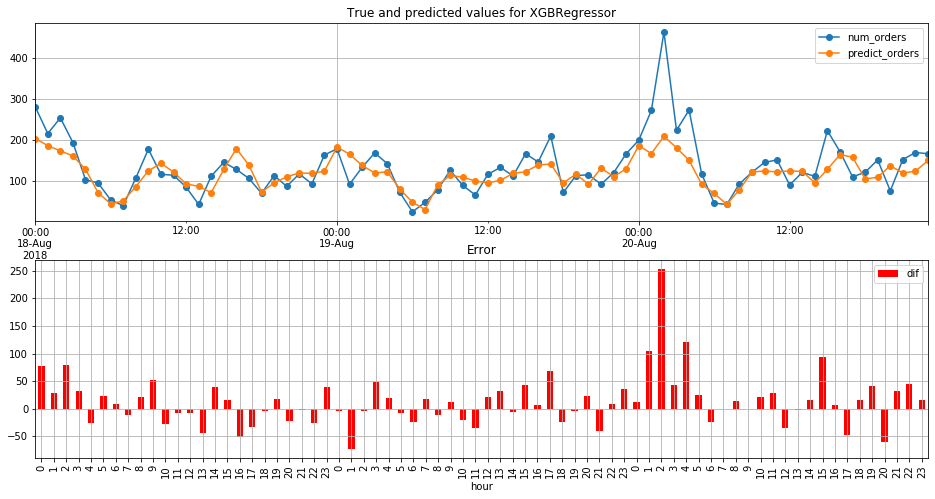

In [20]:
xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(f_train_ohe, t_train)

score_xgb = score_me(xgb_model)
result = result.append({'Model':'XGBoost', 'RMSE':score_xgb}, ignore_index=True)

### 3.5 CatBoost

In [21]:
def CB_cv_grid():
    cb_m = cb.CatBoostRegressor(random_state=112211)

    param_grid = {
            "iterations"        : [500,1000,2000],
            "learning_rate"     : [0.1,0.01],
            "depth" : [1,5]
            }

    cb_grid = GridSearchCV(cb_m, param_grid, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error')
    cb_grid.fit(f_train, t_train, cat_features=cat_features, verbose=False)

    print('...Search completed...')
    print('Best RMSE score', cb_grid.best_score_)
    print('Best params:', cb_grid.best_params_)

    return cb_grid.best_params_

In [22]:
#cb_params=CB_cv_grid()
cb_params = {'depth': 5, 'iterations': 2000, 'learning_rate': 0.01}

RMSE on TRAIN: 18.58165470081351
RMSE on TEST: 42.88905951080156


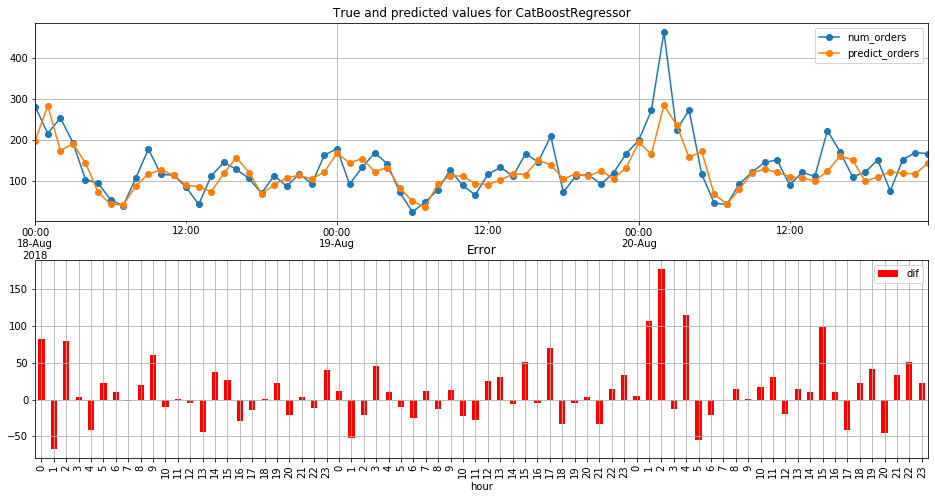

In [23]:
model_cb = cb.CatBoostRegressor(**cb_params, verbose=False)
model_cb.fit(f_train_ohe, t_train)

score_cb = score_me(model_cb)
result = result.append({'Model':'CatBoost', 'RMSE':score_cb}, ignore_index=True)

### 3.6 LightGBM

In [24]:
def LGB_cv_grid():
    lgb_m = lgb.LGBMRegressor(random_state=112211)
    param_grid = {
            "num_leaves"        : [500,1000,2000],
            "learning_rate"     : [1,0.1,0.01],
            "max_depth" : [-1, 5,10],
            "reg_lambda": [1,5,6],
            "min_child_weight" : [1,5]
            }

    lgb_grid = GridSearchCV(lgb_m, param_grid, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error')
    lgb_grid.fit(f_train_ohe,t_train)

    print('...Search completed...')
    print('Best RMSE score', lgb_grid.best_score_)
    print('Best params:', lgb_grid.best_params_)
    return lgb_grid.best_params_


In [25]:
#lgb_params = LGB_cv_grid()

lgb_params = {'learning_rate': 0.1,
              'max_depth': 5,
              'min_child_weight': 1,
              'num_leaves': 500,
              'reg_lambda': 6}

lgb_params

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1,
 'num_leaves': 500,
 'reg_lambda': 6}

RMSE on TRAIN: 19.009597617113933
RMSE on TEST: 42.594067279419946


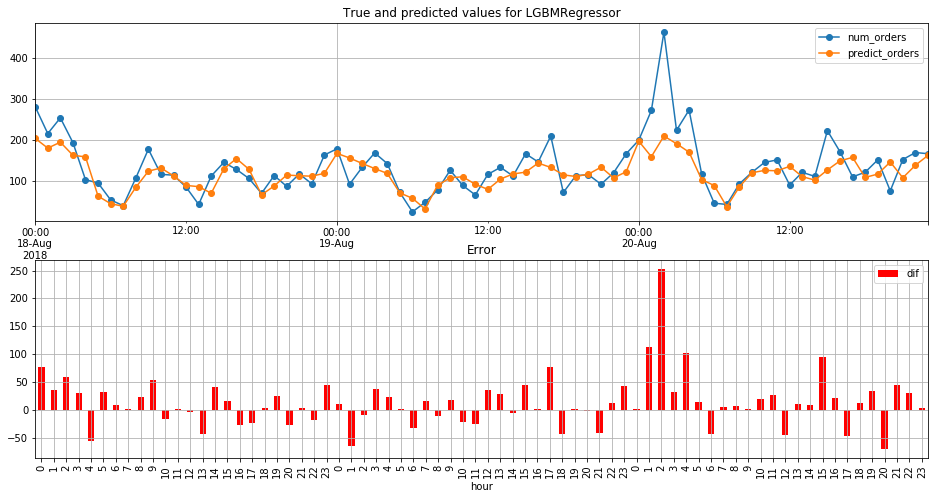

In [26]:
lgb_m = lgb.LGBMRegressor(**lgb_params)
lgb_m.fit(f_train_ohe, t_train)

score_lgb = score_me(lgb_m)
result = result.append({'Model':'LightGBM', 'RMSE':score_lgb}, ignore_index=True)

# 4. Выводы

Целью работы было создание модели для предсказания требуемого количества такси для подачи в аэропорту в следующий час.

Входными данными были данные о загрузке такси с марта по август, с временным интервалом 10 минут.<br/>
Было проведено ресемплирование данных за 1 час.

Для обучения моделей были выделены признаки:
* Среднее кол-во заказов за последние 24 часа (roll_24_mean)
* Данные о кол-ве заказов за последние 6 часов (lag_*)
* Час (hour)
* День недели (weekday)
* Месяц (month)

Категориальные признаки были закодированы OHE. <br/>
Далее были обучены различные модели. Для каждой модели посчитаны значения метрик и построены графики для анализа предсказанных и реальных значений.
Полученные результаты метрик:

In [27]:
result

,Model,RMSE
0,median,87.210938
1,RandomForest,42.474017
2,LinearReg,43.701530
3,XGBoost,44.090839
4,CatBoost,42.889060
5,LightGBM,42.594067


Лучшее качество по метрике RMSE показал RandomForest. Хотя качество LightGBM примерно сравнимо, а вот скорость существенно выше.</br>

P.S.
Интересно, что модели градиентного бустинга не сильно улучшают результаты базовых моделей в этой работе. Возможно, из-за большого кол-ва локальных минимумов, в силу высокой сезонности данных.

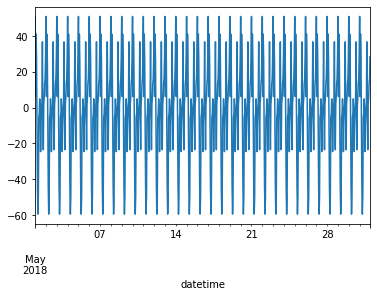

In [28]:
# вот например за май какой ужас))
decomposed = seasonal_decompose(data['2018-05']['num_orders'])
decomposed.seasonal.plot()